# Delay-Doppler v4 GPU

In [1]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.dates import num2date
from matplotlib.ticker import FuncFormatter

import numpy as np

from scipy.signal import chirp, correlate, correlation_lags, find_peaks, hilbert
from scipy.signal import chirp, correlate, find_peaks, hilbert, firwin, butter, lfilter
from tqdm import tqdm

import spiceypy
import spiceypy as sp

import healpy as hp

# CUDA
import cupy as cp
import cupyx as cpx
import cupyx.scipy.signal 

import sigmf

/home_local/thomas/venv/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
import astropy.units as u
from astropy.constants import c as speed_of_light
from astropy.coordinates import EarthLocation, solar_system_ephemeris
from astropy.time import Time
import astropy.constants

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
np.set_printoptions(legacy='1.25')  # Make np.floats print as just numbers

In [5]:
# Set parameters
tx_frequency = 1297.500 * u.MHz
f0 = tx_frequency.value * 1000
fs = 1e6

In [6]:
dwingeloo = EarthLocation(
    lat="52d48m43.27", lon="6d23m46.21", height=60, ellipsoid="WGS84"
)
radius_moon = 1737.4 * u.km
solar_system_ephemeris.set("de430");

In [7]:
def doppler(v,f):
    return (1 - v / astropy.constants.c.value) * f

In [8]:
moon_depth = 2 * (1000 * radius_moon.value / astropy.constants.c.value)

In [9]:
# NUC thomas
rx_dir = "/mnt/ssd/venus/2025-03-11/"
tx_dir = "/mnt/ssd/venus/tx_long/"
kernel_dir = "kernels/"

# Uranus
rx_dir = "/home_local/thomas/data/venus/2025-03-11/"
tx_dir = "/home_local/thomas/data/venus/tx_long/"
kernel_dir = "/home_local/thomas/notebooks/kernels/"

In [10]:
# read RX data file

# 50 kHz
file1 = f"{rx_dir}/stockert_eme_2025_03_11_19_36_21_1297.500MHz_1.00Msps_ci16_le.chan0.sigmf-meta"
file2 = f"{rx_dir}/stockert_eme_2025_03_11_19_36_21_1297.500MHz_1.00Msps_ci16_le.chan1.sigmf-meta"

# 20 kHz
# file1 = "/mnt/ssd/venus/2025-03-11/stockert_eme_2025_03_11_19_35_05_1297.500MHz_1.00Msps_ci16_le.chan0.sigmf-meta"
# file2 = "/mnt/ssd/venus/2025-03-11/stockert_eme_2025_03_11_19_35_05_1297.500MHz_1.00Msps_ci16_le.chan1.sigmf-meta"

# 30x1sec
# file1 = "/mnt/ssd/venus/2025-03-11/stockert_eme_2025_03_11_19_32_39_1297.500MHz_1.00Msps_ci16_le.chan0.sigmf-meta"
# file2 = "/mnt/ssd/venus/2025-03-11/stockert_eme_2025_03_11_19_32_39_1297.500MHz_1.00Msps_ci16_le.chan1.sigmf-meta"

handle = sigmf.sigmffile.fromfile(file1)

data = handle.read_samples().astype("complex64")

handle2 = sigmf.sigmffile.fromfile(file2)

data2 = handle2.read_samples().astype("complex64")

pow_1 = np.mean(np.abs(data))
pow_2 = np.mean(np.abs(data2))

print(pow_1)
print(pow_2)

data2 = data2 * (pow_1 / pow_2)

pow_1 = np.mean(np.abs(data))
pow_2 = np.mean(np.abs(data2))

print(pow_1)
print(pow_2)

# Combine
# RHCP at 80 degrees (cross-pol), LHCP at 260 (co-pol)

data = data + np.exp(1j * 260 * np.pi / 180) * data2

sample_rate = int(handle.get_global_info()[handle.SAMPLE_RATE_KEY])
center_freq = handle.get_capture_info(0)["core:frequency"]
start_time = handle.get_capture_info(0)["core:datetime"]
tx_waveform = handle.get_global_info()["core:description"]

if "dwingeloo" in file1:
    site = "Dwingeloo"
elif "stockert" in file1:
    site = "Stockert"
else:
    site = ""

print(site)

fs = sample_rate
fc = center_freq

f0 = center_freq

print(sample_rate)
print(center_freq)
print(len(data) / fs)
print(start_time)
print(tx_waveform)

0.008461842
0.01888173
0.008461842
0.008461829
Stockert
1000000
1297500000
36.0
2025-03-11T19:36:21.000039
zadoff-chu-50000-1500007-503-0-30-1.sigmf-meta


In [11]:
# Read TX waveform
handle = sigmf.sigmffile.fromfile(tx_dir + tx_waveform)
txsignal = handle.read_samples().astype("complex64");

In [12]:
spiceypy.furnsh(f"{kernel_dir}/naif0012.tls")
spiceypy.furnsh(f"{kernel_dir}/de440s.bsp")
spiceypy.furnsh(f"{kernel_dir}/pck00011.tpc")
spiceypy.furnsh(f"{kernel_dir}/earth_latest_high_prec.bpc")
spiceypy.furnsh(f"{kernel_dir}/observatories.bsp")
spiceypy.furnsh(f"{kernel_dir}/observatories.tf")

In [13]:
# De Bilt
h = 51 / 1000
lon = 5.17973411317635
lat = 52.1018688270963

[dim, radii] = spiceypy.bodvrd("EARTH", "RADII", 3)
flattening = (radii[0] - radii[2]) / radii[0]
debilt_obs = spiceypy.georec(
    lon * np.pi / 180, lat * np.pi / 180, h, radii[0], flattening
)

# Dwingeloo
h = 70.26 / 1000
lon = 6.396346463227839
lat = 52.81213723180477

dwingeloo_obs = spiceypy.georec(
    lon * np.pi / 180, lat * np.pi / 180, h, radii[0], flattening
)

# Stockert
h = 434 / 1000
lon = 6.721943350231514
lat = 50.56944039751571

stockert_obs = spiceypy.georec(
    lon * np.pi / 180, lat * np.pi / 180, h, radii[0], flattening
)

In [14]:
if site == "Dwingeloo":
    current_obs = dwingeloo_obs
else:
    current_obs = stockert_obs

In [15]:
# copied from https://github.com/daniestevez/jupyter_notebooks/blob/master/CAMRAS-EVE/Earth-Venus-Earth%20experiment%20analysis.ipynb

def radar_dlt(target, t_rx, transmitter, receiver=None):
    if receiver is None:
        receiver = transmitter
    ez_r, lt_r = sp.spkezr(target, t_rx, 'J2000', 'CN', receiver)
    ez_d, lt_d = sp.spkezr(transmitter, t_rx - lt_r, 'J2000', 'CN', target)
    dlt_r = sp.dvnorm(ez_r) / sp.clight()
    ez_d[3:] *= 1 - dlt_r
    dlt_d = sp.dvnorm(ez_d) / sp.clight()
    return dlt_r + dlt_d

def radar_lt(target, t_rx, transmitter, receiver=None):
    if receiver is None:
        receiver = transmitter
    ez_r, lt_r = sp.spkezr(target, t_rx, 'J2000', 'CN', receiver)
    ez_d, lt_d = sp.spkezr(transmitter, t_rx - lt_r, 'J2000', 'CN', target)
    return lt_r+lt_d

def radar_surface_dlt(target, surf_vec, surf_frame, t_rx, transmitter, receiver=None):
    if receiver is None:
        receiver = transmitter
    target_radius = sp.bodvrd(target, 'RADII', 3)[1][0]
    surf_vec = np.array(surf_vec)
    surf_vec = target_radius * sp.unorm(surf_vec)[0]
    ez_r, lt_r = sp.spkcpt(surf_vec, target, surf_frame, t_rx, 'J2000', 'OBSERVER', 'CN', receiver)
    ez_d, lt_d = sp.spkcpo(transmitter, t_rx - lt_r, 'J2000', 'OBSERVER', 'CN', surf_vec, target, surf_frame)
    dlt_r = sp.dvnorm(ez_r) / sp.clight()
    ez_d[3:] *= 1 - dlt_r
    dlt_d = sp.dvnorm(ez_d) / sp.clight()
    return dlt_r + dlt_d
    
def radar_srp_dlt(target, target_frame, t_rx, transmitter, receiver=None):
    if receiver is None:
        receiver = transmitter
    srp, t_ref, _ = sp.subpnt('INTERCEPT/ELLIPSOID', target, t_rx, target_frame, 'CN', receiver)
    ez_r, lt_r = sp.spkcpt(srp, target, target_frame, t_rx, 'J2000', 'OBSERVER', 'CN', receiver)
    assert np.abs(t_rx - t_ref - lt_r) < 1e-6
    ez_d, lt_d = sp.spkcpo(transmitter, t_rx - lt_r, 'J2000', 'OBSERVER', 'CN', srp, target, target_frame)
    dlt_r = sp.dvnorm(ez_r) / sp.clight()
    ez_d[3:] *= 1 - dlt_r
    dlt_d = sp.dvnorm(ez_d) / sp.clight()
    return dlt_r + dlt_d

def radar_srp_lt(target, target_frame, t_rx, transmitter, receiver=None):
    if receiver is None:
        receiver = transmitter
    srp, t_ref, _ = sp.subpnt('INTERCEPT/ELLIPSOID', target, t_rx, target_frame, 'CN', receiver)
    ez_r, lt_r = sp.spkcpt(srp, target, target_frame, t_rx, 'J2000', 'OBSERVER', 'CN', receiver)
    assert np.abs(t_rx - t_ref - lt_r) < 1e-6
    ez_d, lt_d = sp.spkcpo(transmitter, t_rx - lt_r, 'J2000', 'OBSERVER', 'CN', srp, target, target_frame)
    return lt_r+lt_d

def offnormal_angle(target, surf_vec, surf_frame, t_rx, transmitter, receiver):
    target_radius = sp.bodvrd(target, 'RADII', 3)[1][0]
    surf_vec = np.array(surf_vec)
    surf_vec = target_radius * sp.unorm(surf_vec)[0]
    _, lt_r = sp.spkcpt(surf_vec, target, surf_frame, t_rx, 'J2000', 'OBSERVER', 'CN', receiver)
    pos_r, lt_r = sp.spkcpo(receiver, t_rx - lt_r, 'J2000', 'OBSERVER', 'XCN+S', surf_vec, target, surf_frame)
    pos_r = pos_r[:3]
    pos_d, _ = sp.spkcpo(transmitter, t_rx - lt_r, 'J2000', 'OBSERVER', 'CN+S', surf_vec, target, surf_frame)
    pos_d = pos_d[:3]
    surf_norm = sp.unorm(sp.mxv(sp.pxform(surf_frame, 'J2000', t_rx - lt_r), surf_vec))[0]
    scattering = sp.unorm(sp.unorm(pos_r)[0] + sp.unorm(pos_d)[0])[0]
    return np.rad2deg(np.arccos(np.dot(scattering, surf_norm)))

In [16]:
# Create kernels for Moon surface
NSIDE = 30
healpix_resol_deg = hp.nside2resol(NSIDE, arcmin=True) / 60
NPIX = hp.nside2npix(NSIDE)
print(f"HEALPix approx. resolution = {healpix_resol_deg:.2f} deg, NPIX = {NPIX}")

HEALPix approx. resolution = 1.95 deg, NPIX = 10800


In [17]:
# Moon
[dim, radii] = spiceypy.bodvrd("MOON", "RADII", 3)
moon_radius = radii[0] * 1000
moon_radius

1737400.0

In [18]:
time_astropy = Time(start_time)
et = spiceypy.str2et(Time(time_astropy.isot).utc.value)

In [19]:
duration = len(data) / sample_rate
print(duration)

36.0


In [20]:
trx = Time(time_astropy.isot) + np.arange(int(duration)) * u.s
utcs = trx.utc.value
# utcs

In [21]:
dlts = np.array([radar_dlt('MOON', sp.str2et(utc), transmitter='DWINGELOO', receiver=site) for utc in utcs])
# lts = np.array([radar_lt('MOON', sp.str2et(utc), transmitter='DWINGELOO', receiver=site) for utc in utcs])
dlts_srp = np.array([radar_srp_dlt('MOON', 'IAU_MOON', sp.str2et(utc), transmitter='DWINGELOO', receiver=site) for utc in utcs])
lts = np.array([radar_srp_lt('MOON', 'IAU_MOON', sp.str2et(utc), transmitter='DWINGELOO', receiver=site) for utc in utcs])

In [22]:
lts[0]

2.59243642377109

In [23]:
utcs_dt64 = np.array([np.datetime64(utc) for utc in utcs])

In [24]:
-dlts[0] * f0

1046.6694513021773

In [25]:
# -dlts * f0

In [26]:
utc_subsample = [0]
dlt_surface = np.array(
    [[radar_surface_dlt('MOON', hp.pix2vec(NSIDE, n), 'IAU_MOON', sp.str2et(utcs[k]), transmitter='DWINGELOO', receiver=site)
      for k in utc_subsample]
     for n in range(NPIX)]
)

In [27]:
angles_surface = np.array(
    [[offnormal_angle('MOON', hp.pix2vec(NSIDE, n), 'IAU_MOON', sp.str2et(utcs[k]), transmitter='DWINGELOO', receiver=site)
      for k in utc_subsample]
     for n in range(NPIX)]
)

In [28]:
srp, _ = sp.spkpos('DWINGELOO', sp.str2et(utcs[0]), 'IAU_MOON', 'CN+S', 'MOON')
srp = np.rad2deg(sp.reclat(srp)[1:])
srp

array([ 5.65155064, -3.34912792])

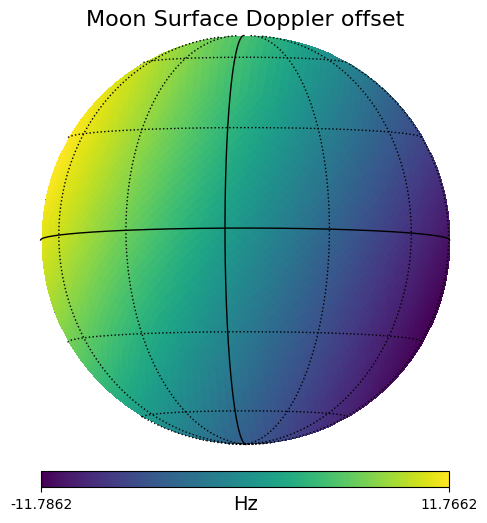

In [29]:
dlt_surface_filt = np.copy(dlt_surface)
dlt_surface_filt[angles_surface > 90] = np.nan

doppler_surface_offset = -(dlt_surface_filt - dlts[utc_subsample]) * f0

hp.orthview(doppler_surface_offset[:, 0], flip='geo', rot=srp, half_sky=True,
            title='Moon Surface Doppler offset', unit='Hz')
hp.graticule()

In [30]:
doppler_offset_max = np.nanmax(doppler_surface_offset, axis=0)
doppler_offset_min = np.nanmin(doppler_surface_offset, axis=0)
print(doppler_offset_max)
print(doppler_offset_min)

[11.76623384]
[-11.78622805]


In [31]:
f0 = center_freq
v_down = np.zeros(int(duration))
v_up = np.zeros(int(duration))
d = np.zeros(int(duration))
lighttime_up = np.zeros(int(duration))
lighttime_down = np.zeros(int(duration))

In [32]:
for t in range(int(duration)):
    timestamp = Time(time_astropy.isot) + float(t) * u.s
    et = spiceypy.str2et(timestamp.utc.value)
    [azlsta, lt] = spiceypy.azlcpo("ELLIPSOID", "Moon", et, "CN+S", False, True, current_obs, "EARTH", "ITRF93")
    v_down[t] = 1000 * azlsta[3]
    d[t] = 1000 * azlsta[0]
    lighttime_down[t] = lt - moon_radius / astropy.constants.c.value

In [33]:
for t in range(int(duration)):
    timestamp = Time(time_astropy.isot) + float(t) * u.s - 2 * lighttime_down[t] * u.s
    et = spiceypy.str2et(timestamp.utc.value)
    [azlsta, lt] = spiceypy.azlcpo("ELLIPSOID", "Moon", et, "XCN+S", False, True, dwingeloo_obs, "EARTH", "ITRF93")
    v_up[t] = 1000 * azlsta[3]
    lighttime_up[t] = lt - moon_radius / astropy.constants.c.value

In [34]:
print(lighttime_up[0])
print(lighttime_down[0])
print(lighttime_up[0] + lighttime_down[0])

1.2963635011356596
1.2960728209071488
2.5924363220428086


In [35]:
dop_up = doppler(v_up, f0) - f0
dop_down = doppler(v_down, f0) - f0
print(dop_up + dop_down)

[1046.67433786 1046.54325581 1046.41216683 1046.28107095 1046.14996743
 1046.01885653 1045.8877387  1045.75661325 1045.62548089 1045.49434114
 1045.36319447 1045.23204017 1045.10087919 1044.96971011 1044.83853436
 1044.70735121 1044.57616115 1044.44496322 1044.31375861 1044.18254638
 1044.05132747 1043.92010093 1043.788867   1043.65762639 1043.52637815
 1043.39512277 1043.26386023 1043.13259029 1043.00131297 1042.87002897
 1042.73873734 1042.60743856 1042.47613239 1042.34481955 1042.21349907
 1042.08217144]


In [36]:
np.mean(np.diff(dop_up + dop_down))

-0.13120475496564593

In [37]:
np.diff(-dlts * f0)

array([-0.13108146, -0.13108865, -0.13109594, -0.13110315, -0.13111042,
       -0.13111761, -0.1311249 , -0.1311321 , -0.13113935, -0.13114657,
       -0.13115384, -0.13116105, -0.13116829, -0.13117551, -0.13118278,
       -0.13118998, -0.13119722, -0.13120444, -0.13121167, -0.13121891,
       -0.13122613, -0.13123339, -0.13124058, -0.13124783, -0.13125504,
       -0.1312623 , -0.13126949, -0.13127673, -0.13128394, -0.13129119,
       -0.13129837, -0.13130564, -0.13131282, -0.13132008, -0.13132725])

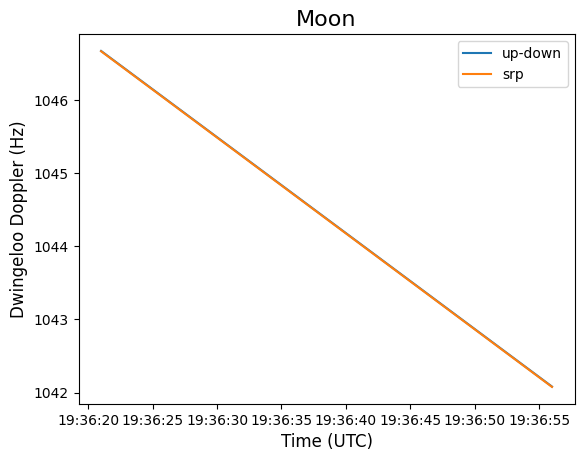

In [38]:
time_range = time_astropy + np.arange(len(dop_down)) * u.s

fig, ax = plt.subplots()
ax.plot(time_range.datetime, (dop_up + dop_down), "-", label="up-down")
ax.plot(time_range.datetime, (-dlts * f0), "-", label="srp")
# ax.plot(time_range.datetime[1:], np.diff(dop_up+dop_down), "-", label="up-down");
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Dwingeloo Doppler (Hz)")
ax.xaxis_date()
ax.legend()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{num2date(x):%H:%M:%S}"))

ax.set_title("Moon");

In [39]:
# SPICE
td = 0  # Doppler at T0
freq_offset = -dlts[0] * f0  # dop_up[td]+dop_down[td]

# if (site=="Stockert"):
#     freq_offset -= 808.8 # Stockert 2025_03_04_15_48_13
#     freq_offset -= 810.4 # Stockert 2025_03_04_16_02_48
expected_freq_offset = freq_offset
expected_delay = lighttime_up[td] + lighttime_down[td]

print(f"Expected Doppler offset: {freq_offset:.3f} Hz")
print(f"Expected delay: {expected_delay:.6f} s")

Expected Doppler offset: 1046.669 Hz
Expected delay: 2.592436 s


In [40]:
dr = np.mean(np.diff(-dlts * f0))
dr

-0.13120441741179353

In [41]:
drs = np.diff(-dlts * f0)
drs = np.append(drs, drs[-1])
blocks = int(len(data) / len(drs))
dr_vec = np.repeat(drs, blocks)

In [42]:
# transmission_start = .200008 # seconds (2021)
# transmission_start = 1.000008 # seconds (2 MHz)
# transmission_start = 1.000011 # seconds (1 MHz)

transmission_start = 1.000011 - 11.926e-6  # seconds, Stockert, correct for H-maser offset Dwingeloo (1 MHz)

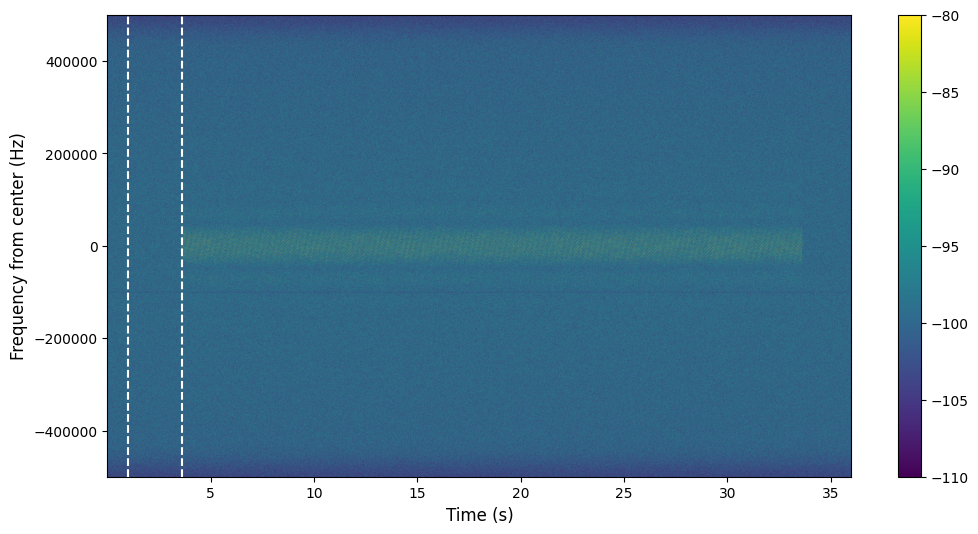

In [43]:
# show spectrogram of raw data
fig, ax0 = plt.subplots(figsize=(12, 6))
vmin = 20 * np.log10(np.max(data)) - 40  # hide anything below -40 dBc
pxx, freq, t, cax = ax0.specgram(data, Fs=fs, NFFT=8 * 1024, clim=[-110, -80])
# ax0.set_ylim([0e3, 500e3])
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Frequency from center (Hz)")
ax0.axvline(transmission_start, color="white", linestyle="--")
ax0.axvline(transmission_start + expected_delay, color="white", linestyle="--")
fig.colorbar(cax);

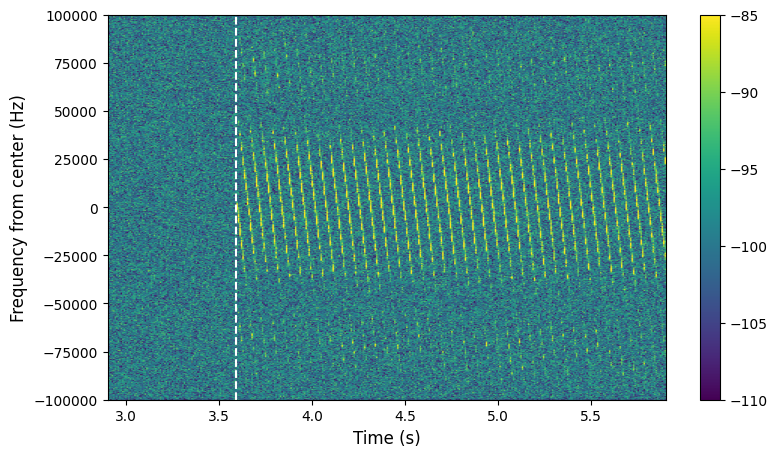

In [44]:
fig, ax0 = plt.subplots(figsize=(9, 5))
vmin = 20 * np.log10(np.max(data)) - 40  # hide anything below -40 dBc
pxx, freq, t, cax = ax0.specgram(data, Fs=fs, NFFT=8 * 1024, clim=[-110, -85])
ax0.set_ylim([-100e3, 100e3])
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Frequency from center (Hz)")
ax0.axvline(transmission_start + expected_delay, color="white", linestyle="--")
# ax0.axvline(transmission_start, color="white", linestyle="--")
ax0.set_xlim(2.9, 5.9)
# ax0.set_xlim(3.38,3.42)
fig.colorbar(cax);

In [45]:
cor = correlate(data, txsignal, mode="full")
lags = correlation_lags(len(data), len(txsignal), mode="full")

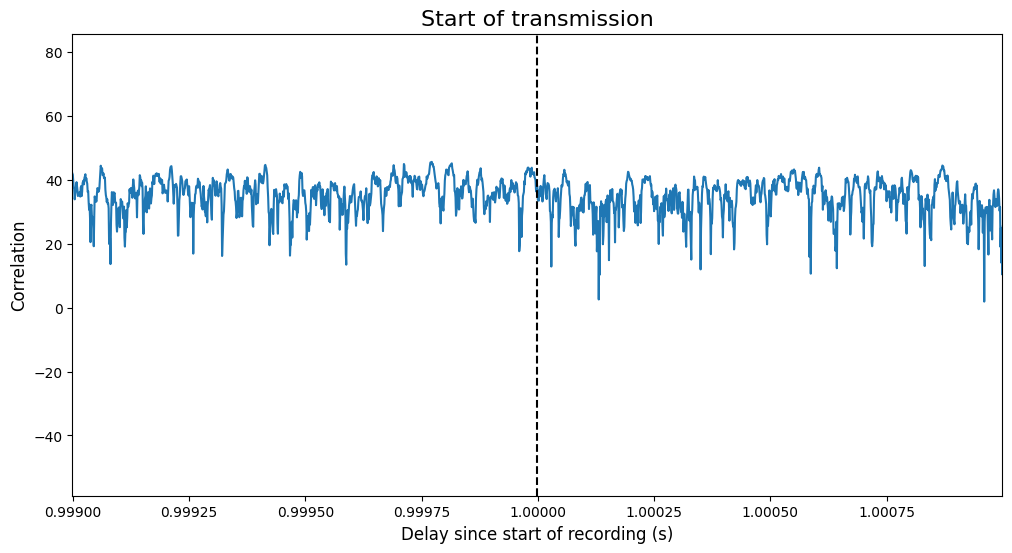

In [46]:
# Determine start of transmission (hardcoded above)
fig, ax0 = plt.subplots(figsize=(12, 6))
ax0.plot(lags / fs, 20 * np.log10(abs(cor)), label="signal")
ax0.set_xlim([transmission_start - 0.001, transmission_start + 0.001])
# ax0.set_xlim([transmission_start-0.0001, transmission_start+0.0001])
# ax0.set_ylim([10, 70])
ax0.set_xlabel("Delay since start of recording (s)")
ax0.set_title("Start of transmission")
ax0.set_ylabel("Correlation")
ax0.axvline(transmission_start, color="black", linestyle="--");

In [47]:
# Compensate for Doppler and Doppler rate
t_s = np.arange(len(data))/fs
# fdrift = -dr; # Doppler rate
fdrift = -dr_vec;
f0_Hz = -expected_freq_offset # Doppler
phi_Hz = (fdrift * t_s**2)/2 + (f0_Hz * t_s) # Instantaneous phase.
phi_rad = 2 * np.pi * phi_Hz # Convert to radians.
data = data*np.exp(1j * phi_rad)

expected_freq_offset = 0
freq_offset = 0

In [48]:
print(f"Expected Doppler offset: {freq_offset:.3f} Hz")
print(f"Expected delay: {expected_delay:.6f} s")

Expected Doppler offset: 0.000 Hz
Expected delay: 2.592436 s


In [49]:
this_dechirp = txsignal * np.transpose(
    np.exp(-1j * 2 * np.pi * (-freq_offset / fs) * (np.arange(len(txsignal))))
)
cor = correlate(data, this_dechirp, mode="full")
lags = correlation_lags(len(data), len(this_dechirp), mode="full")

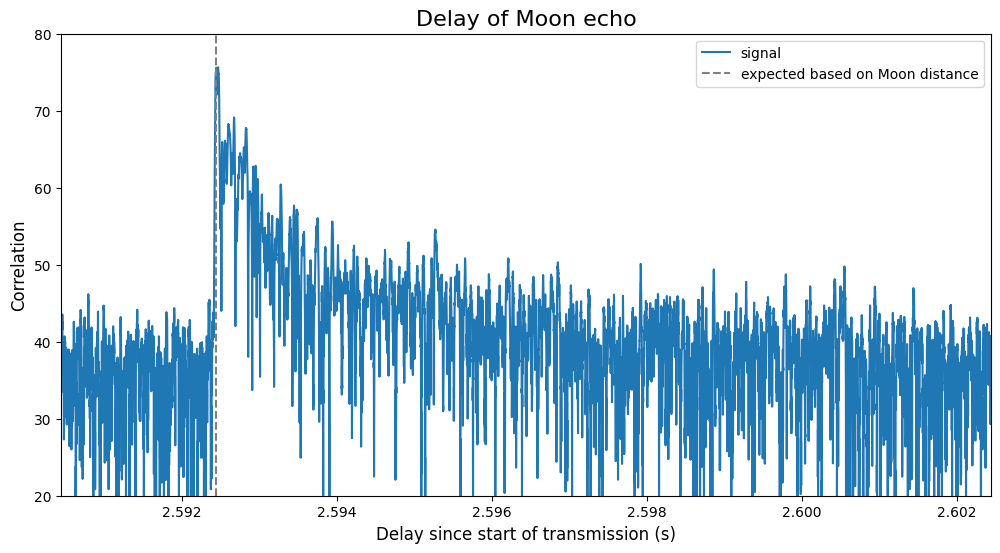

In [50]:
# show correlation peak in time of moon echo
fig, ax0 = plt.subplots(figsize=(12, 6))
ax0.plot((lags / fs) - transmission_start, 20 * np.log10(abs(cor)), label="signal")
ax0.set_xlim([expected_delay - 0.002, expected_delay + 0.010])

ax0.set_ylim([20, 80])
ax0.axvline(
    expected_delay,
    linestyle="--",
    color="grey",
    label="expected based on Moon distance",
)
ax0.set_xlabel("Delay since start of transmission (s)")
ax0.set_title("Delay of Moon echo")
ax0.legend(loc="upper right")
ax0.set_ylabel("Correlation");

## Delay-Doppler analysis

In [53]:
# Set ranges for Delay-Doppler analysis

f_start = freq_offset + 15  # Hz
f_stop = freq_offset - 15

freq_axis = np.arange(f_start, f_stop - 1e-12, -0.05)
print(len(freq_axis))

t_start = transmission_start + expected_delay - 0.001  # seconds
t_stop = transmission_start + expected_delay + moon_depth + 0.002

time_axis = np.arange(t_start, t_stop, 1 / fs) * fs

601


In [52]:
###### Calculate Delay-Doppler correlations (takes some time)
# Note: applying a window function to the txsignal reduces the side lobes, but widens the main lobe and reduces the correlation power

delay_doppler = np.zeros((len(freq_axis), len(time_axis) - 1))

# Use CUDA
cu_txsignal = cp.asarray(txsignal, dtype="complex64")
cu_data = cp.asarray(data, dtype="complex64")

lags = correlation_lags(len(data), len(txsignal), mode="valid") / fs
subset = (lags >= t_start) & (lags <= t_stop)

for i, this_freq_offset in enumerate(tqdm(freq_axis)):

    chirp_padded = cp.pad(
        cu_txsignal
        # * cp.blackman(len(txsignal))
        * cp.exp(-1j * 2 * cp.pi * (-this_freq_offset / fs) * cp.arange(len(txsignal))).T,
        (0, len(data) - len(txsignal)),
        mode="constant",
    )

    cor = cp.fft.ifft(
        cp.fft.fft(cu_data)
        * cp.conj(cp.fft.fft(cp.asarray(chirp_padded, dtype="complex64")))
    )
    cor = cor[: len(lags)]
    cor = cp.abs(cor) ** 2
    this_cor = cor[subset]
    delay_doppler[i, :] = cp.asnumpy(cp.abs(this_cor[: len(time_axis) - 1]))

delay_doppler = 10 * np.log10(delay_doppler);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 601/601 [00:38<00:00, 15.72it/s]


In [54]:
np.save("delay_doppler_stockert_combined_2025_03_11_19_36_21.npy", delay_doppler)

In [55]:
max_power = np.max(delay_doppler)
max_power

80.97007645329988

In [56]:
min_power = np.quantile(delay_doppler, 0.05)
min_power

26.66427336643925

In [57]:
snr = max_power - min_power
snr

54.305803086860635

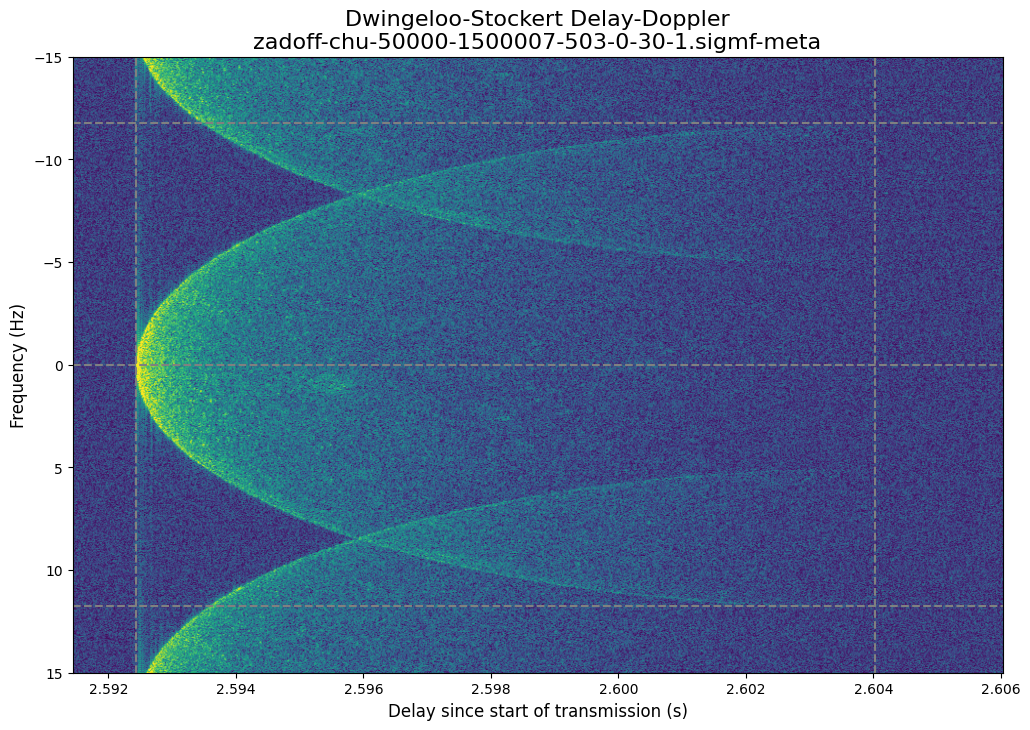

In [58]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(
    delay_doppler,
    extent=[
        time_axis[0] / fs - transmission_start,
        time_axis[-1] / fs - transmission_start,
        freq_axis[0],
        freq_axis[-1],
    ],
    aspect="auto",
    vmin=max_power - 27 * 2,
    vmax=max_power - 5 * 2,
)
ax.set_title("Dwingeloo-" + site + " Delay-Doppler" + "\n" + tx_waveform)
ax.set_xlabel("Delay since start of transmission (s)")
ax.set_ylabel("Frequency (Hz)")
ax.axhline(expected_freq_offset, linestyle="--", color="grey")
ax.axvline(expected_delay, linestyle="--", color="grey")
ax.axvline(expected_delay + moon_depth, linestyle="--", color="grey")

ax.axhline(doppler_offset_max, linestyle="--", color="grey")
ax.axhline(doppler_offset_min, linestyle="--", color="grey");

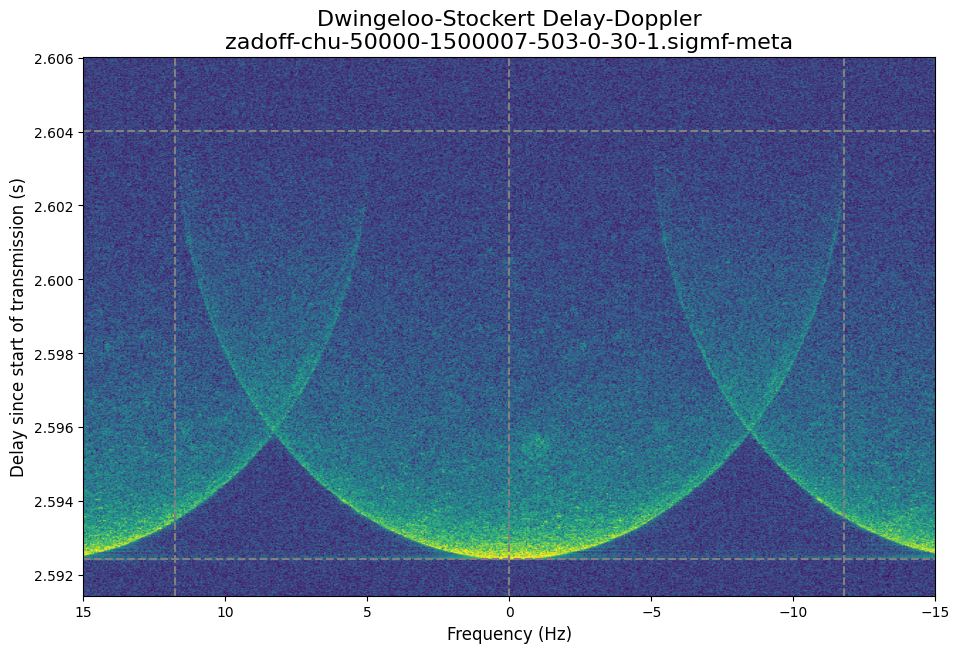

In [59]:
fig, ax = plt.subplots(figsize=(11, 7))
ax.imshow(
    np.flipud(delay_doppler.T),
    extent=[
        freq_axis[0],
        freq_axis[-1],
        time_axis[0] / fs - transmission_start,
        time_axis[-1] / fs - transmission_start,
    ],
    aspect="auto",
#     vmin=max_power-26, vmax=max_power-5
    vmin=max_power-27*2, vmax=max_power-6*2
)
ax.set_title("Dwingeloo-"+site+" Delay-Doppler"+"\n"+tx_waveform)
ax.set_ylabel("Delay since start of transmission (s)")
ax.set_xlabel("Frequency (Hz)");
fig.savefig("delay-doppler.png")
ax.axhline(
    expected_delay,
    linestyle="--",
    color="grey",
    label="expected based on Moon distance",
);
ax.axhline(
    expected_delay+moon_depth,
    linestyle="--",
    color="grey",
    label="expected based on Moon distance",
);
ax.axvline(
    expected_freq_offset,
    linestyle="--",
    color="grey",
    label="expected based on Moon distance",
);

ax.axvline(doppler_offset_max,linestyle="--",color="grey")
ax.axvline(doppler_offset_min,linestyle="--",color="grey");

In [60]:
delay_doppler.shape

(601, 14590)

In [61]:
# np.save("dd_cross", delay_doppler)

In [ ]:
dd_co = np.load("dd_co.npy")
dd_cross = np.load("dd_cross.npy")

In [ ]:
dd_combined = 10 * np.log10(2 * 10 ** (dd_co / 10) + 10 ** (dd_cross / 10))
max_power = np.max(dd_combined)

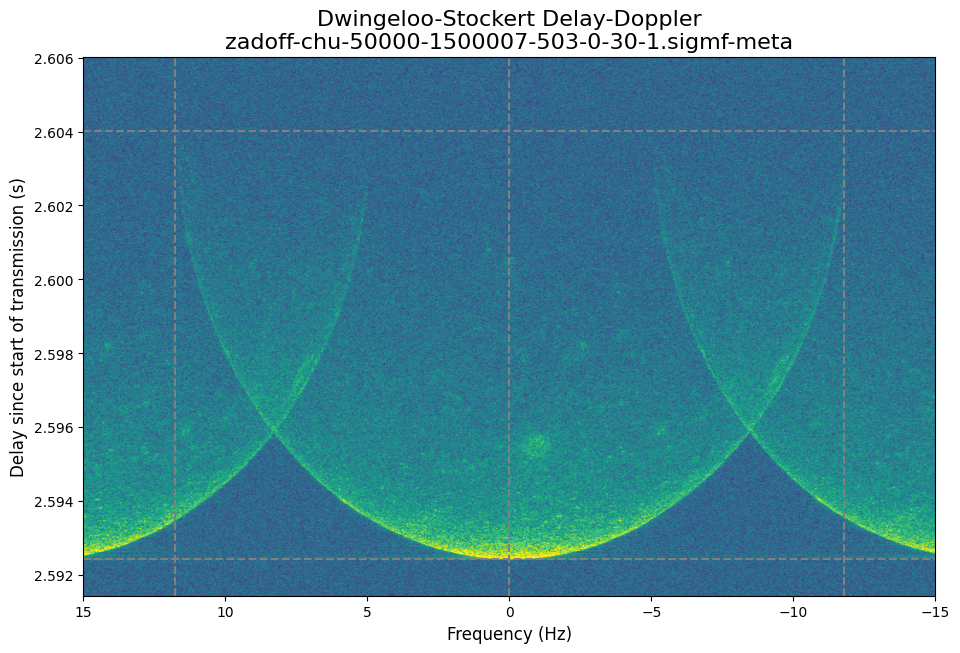

In [61]:
fig, ax = plt.subplots(figsize=(11, 7))
ax.imshow(
    np.flipud(dd_combined.T),
    extent=[
        freq_axis[0],
        freq_axis[-1],
        time_axis[0] / fs - transmission_start,
        time_axis[-1] / fs - transmission_start,
    ],
    aspect="auto",
    vmin=max_power-54, vmax=max_power-12
);
ax.set_title("Dwingeloo-"+site+" Delay-Doppler"+"\n"+tx_waveform)
ax.set_ylabel("Delay since start of transmission (s)")
ax.set_xlabel("Frequency (Hz)");
fig.savefig("delay-doppler.png")
ax.axhline(
    expected_delay,
    linestyle="--",
    color="grey",
    label="expected based on Moon distance",
);
ax.axhline(
    expected_delay+moon_depth,
    linestyle="--",
    color="grey",
    label="expected based on Moon distance",
);
ax.axvline(
    expected_freq_offset,
    linestyle="--",
    color="grey",
    label="expected based on Moon distance",
);

ax.axvline(doppler_offset_max,linestyle="--",color="grey")
ax.axvline(doppler_offset_min,linestyle="--",color="grey");